In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [2]:
directory = 'Dillards POS/'
skst_file_path = directory + 'skstinfo.csv'
trans_file_path = directory + 'trans_final.csv'

#sku_file_path = directory + 'skuinfo.csv'
#sku_retail_file_path = directory + 'sku_retail.csv'
clean_sku_file_path = directory + 'sku_final.csv'

In [3]:
def prepare_basket(trans_file_path, skst_file_path):
    ''' function that prepares basket from the transaction table'''
    
    # Transaction table
    trans = pd.read_csv(trans_file_path)
    trans.columns = ['sku', 'storeid', 'register', 'trannum', 'interID', 'saledate', 'stype', 'quantity',
                 'orgprice', 'amt', 'seq', 'mic', 'unkown']
    # Drop all returns
    trans = trans[trans['stype'] == 'P']
    
    trans = trans[trans['amt'] > 1]
    trans = trans[trans['orgprice'] > 1]
    
    # Drop columns irrelevant to basket
    trans.drop(columns=['interID', 'stype', 'mic', 'unkown'], inplace=True)
    
    # skst table
    skst = pd.read_csv(skst_file_path, header = None)
    skst.columns = ['sku', 'storeid', 'cost', 'retail', 'unknown']
    
    # Drop columns irrelevant to basket
    skst.drop(columns = ['unknown'], inplace=True)
    
    # Get non zero mean retail for each sku
    mean_retail = skst.groupby('sku')['retail'].unique().reset_index()
    mean_retail['retail'] = mean_retail['retail'].apply(
        lambda x: sum(x) / len(x) if len(x) > 0 else 0 if len([i for i in x if i != 0]) > 0 else 0
    )
    mean_retail = mean_retail.set_index('sku')
    mean_retail_series = mean_retail['retail']
    
    # Merge transaction and skst
    trans = pd.merge(trans, skst, on=['sku','storeid'], how='left')
    
    # Fill NaN values in 'retail' with the mean retail
    trans['retail'] = trans['retail'].fillna(trans['sku'].map(mean_retail_series))
    # Fill NaN values in 'retail' with the corresponding 'orgprice' values
    trans['retail'] = trans['retail'].fillna(trans['orgprice'])
    
    # Fill NaN values in 'orgprice' with the mean retail
    trans['orgprice'] = trans['orgprice'].fillna(trans['sku'].map(mean_retail_series))
    
    
    # Feature engineering
    
    trans['saledate'] = pd.to_datetime(trans['saledate'])
    # day of week as a number (Monday=0, Sunday=6)
    trans['day_of_week'] = trans['saledate'].dt.dayofweek
    # month as a number
    trans['month'] = trans['saledate'].dt.month
    # Define weekend as Friday (4) to Sunday (6)
    trans['weekend'] = trans['day_of_week'].apply(lambda x: 1 if x >= 4 else 0)
    
    condition_retail_zero = trans['amt'] == 0
    trans.loc[condition_retail_zero, 'amt'] = trans['retail']
    condition_retail_zero = trans['amt'] == 0
    trans.loc[condition_retail_zero, 'amt'] = trans['orgprice']
    
    trans['percent_discount'] = (trans['orgprice'] - trans['amt']) / trans['orgprice']
    condition_retail_greater = trans['amt'] >= trans['orgprice']
    trans.loc[condition_retail_greater, 'percent_discount'] = 0
    condition_retail_zero = trans['orgprice'] <= 0
    trans.loc[condition_retail_zero, 'percent_discount'] = 0
    condition_discount_zero = trans['percent_discount'] < 0
    trans.loc[condition_discount_zero, 'percent_discount'] = 0
    
    
    # final sale defined as > 50% discount
    trans['final_sale'] = np.where(trans['percent_discount']>0.5, 1, 0)
    return trans

In [4]:
basket = prepare_basket(trans_file_path, skst_file_path)
basket.head()

,sku,storeid,register,trannum,saledate,quantity,orgprice,amt,seq,cost,retail,day_of_week,month,weekend,percent_discount,final_sale
0,1658506,9709,80,4600,2004-10-08,1,13.5,13.5,530400071,8.1,13.5,4,10,1,0.0,0
1,1658506,9709,80,4600,2005-04-12,1,13.5,13.5,556900050,8.1,13.5,1,4,0,0.0,0
2,1658506,9709,80,4700,2004-09-18,1,13.5,13.5,908400195,8.1,13.5,5,9,1,0.0,0
3,1658506,9709,80,4800,2005-06-03,1,13.5,13.5,839200063,8.1,13.5,4,6,1,0.0,0
4,1658506,9709,80,4900,2004-10-15,1,13.5,13.5,78400078,8.1,13.5,4,10,1,0.0,0


In [5]:
basket.shape

(109641503, 16)

In [6]:
def join_dataframes(input_df, csv_file_path, columns, join_key = 'sku', how='inner'):
    """
    Joins an input DataFrame with a DataFrame loaded from a CSV file.

    """
    
    columns = columns  + [join_key]
    # Load the second DataFrame from the CSV file
    csv_df = pd.read_csv(csv_file_path)
    csv_df.columns = ['sku', 'deptid', 'classid', 'upc', 'style', 'color', 'size', 'packsize',
                 'vendor', 'brand']

    # Perform the join
    joined_df = pd.merge(input_df, csv_df[columns], on=join_key, how=how)

    return joined_df

In [7]:
#basket = basket.head(10000)

In [8]:
columns = ['brand', 'classid']
joined_df = join_dataframes(basket, clean_sku_file_path, columns)
joined_df.head()

,sku,storeid,register,trannum,saledate,quantity,orgprice,amt,seq,cost,retail,day_of_week,month,weekend,percent_discount,final_sale,brand,classid
0,1658506,9709,80,4600,2004-10-08,1,13.5,13.5,530400071,8.1,13.5,4,10,1,0.0,0,CLINIQUE,007
1,1658506,9709,80,4600,2005-04-12,1,13.5,13.5,556900050,8.1,13.5,1,4,0,0.0,0,CLINIQUE,007
2,1658506,9709,80,4700,2004-09-18,1,13.5,13.5,908400195,8.1,13.5,5,9,1,0.0,0,CLINIQUE,007
3,1658506,9709,80,4800,2005-06-03,1,13.5,13.5,839200063,8.1,13.5,4,6,1,0.0,0,CLINIQUE,007
4,1658506,9709,80,4900,2004-10-15,1,13.5,13.5,78400078,8.1,13.5,4,10,1,0.0,0,CLINIQUE,007


In [ ]:
# Filter values between 0.2 and 0.4
filtered_percent_discount = joined_df[(joined_df['percent_discount'] > 0.2) & (joined_df['percent_discount'] < 0.4)]

# Sort by percent_discount in descending order
filtered_percent_discount = filtered_percent_discount.sort_values(by='percent_discount', ascending=False)

# Display the top rows
filtered_percent_discount.head()

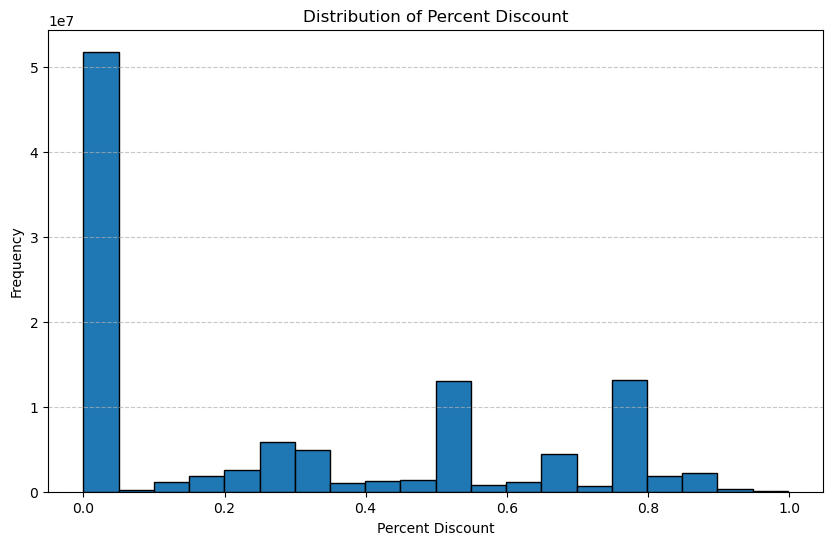

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Assuming 'joined_df' is your DataFrame
percent_discount = joined_df['percent_discount']

# Filter out non-finite values
valid_percent_discount = percent_discount[np.isfinite(percent_discount)]

# Plot histogram
plt.figure(figsize=(10, 6))
plt.hist(valid_percent_discount, bins=20, edgecolor='black')

plt.xlabel('Percent Discount')
plt.ylabel('Frequency')
plt.title('Distribution of Percent Discount')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

In [10]:
joined_df.shape

(109641471, 18)

## Filter non Relevant SKUs

### 1. Filter high revenue sku

In [11]:
def get_high_value_df(joined_df, n=50):
    # Calculate the sum of revenue for each SKU
    sku_sum_revenue = joined_df.groupby('sku')['amt'].sum()

    # Sort SKUs by sum of revenue in descending order
    sorted_skus = sku_sum_revenue.sort_values(ascending=False).reset_index()

    # Calculate cumulative sum of revenue
    sorted_skus['cumulative_sum'] = sorted_skus['amt'].cumsum()
    
    # Calculate the threshold for high-value SKUs
    max_revenue = sorted_skus['cumulative_sum'].max() / (100 / n)
    
    # Filter high-value SKUs
    high_value_skus = sorted_skus[sorted_skus.cumulative_sum < max_revenue]
    
    # Filter the original DataFrame to include only high-value SKUs
    high_value_df = joined_df[joined_df['sku'].isin(high_value_skus['sku'])]
    
    return high_value_df

In [12]:
high_value_df = get_high_value_df(joined_df, n=50)
print(high_value_df["amt"].sum())

1339771413.5500014


In [13]:
high_value_df.head()

,sku,storeid,register,trannum,saledate,quantity,orgprice,amt,seq,cost,retail,day_of_week,month,weekend,percent_discount,final_sale,brand,classid
0,1658506,9709,80,4600,2004-10-08,1,13.5,13.5,530400071,8.1,13.5,4,10,1,0.0,0,CLINIQUE,007
1,1658506,9709,80,4600,2005-04-12,1,13.5,13.5,556900050,8.1,13.5,1,4,0,0.0,0,CLINIQUE,007
2,1658506,9709,80,4700,2004-09-18,1,13.5,13.5,908400195,8.1,13.5,5,9,1,0.0,0,CLINIQUE,007
3,1658506,9709,80,4800,2005-06-03,1,13.5,13.5,839200063,8.1,13.5,4,6,1,0.0,0,CLINIQUE,007
4,1658506,9709,80,4900,2004-10-15,1,13.5,13.5,78400078,8.1,13.5,4,10,1,0.0,0,CLINIQUE,007


### 2. Filter discounted SKUs

In [14]:
def filter_min_average_discount(high_value_df, percentage_column='percent_discount', min_average_discount=0.03):
    # Calculate average percent_discount for each SKU
    average_discount = high_value_df.groupby('sku')[percentage_column].mean().reset_index(name='avg_discount')
    
    # Filter out SKUs based on the minimum average discount
    filtered_df = average_discount[average_discount['avg_discount'] >= min_average_discount]
    
    # Merge the average discount back to the original DataFrame
    merged_df = pd.merge(high_value_df, filtered_df, on='sku', how='inner')
    
    return merged_df

In [15]:
filtered_df = filter_min_average_discount(high_value_df)
filtered_df.shape

(23900020, 19)

### Filter not changing discount SKUs

In [ ]:
def filter_min_average_discount(high_value_df, percentage_column='percent_discount', min_average_discount=0.03):
    # Calculate average percent_discount for each SKU
    average_discount = high_value_df.groupby('sku')[percentage_column].mean()
    
    # Filter out SKUs based on the minimum average discount
    filtered_df = high_value_df.copy()
    for sku, avg_discount in average_discount.items():
        sku_rows = (filtered_df['sku'] == sku)
        if avg_discount < min_average_discount:
            filtered_df = filtered_df[~sku_rows]
    
    return filtered_df

### After Filter df

In [20]:
joined_df = filtered_df.copy()
joined_df.head()

,sku,storeid,register,trannum,saledate,quantity,orgprice,amt,seq,cost,retail,day_of_week,month,weekend,percent_discount,final_sale,brand,classid,avg_discount
0,1658516,102,80,1500,2005-08-26,1,30.0,19.99,583300105,11.86,30.0,4,8,1,0.333667,0,MAIN ING,001,0.220932
1,1658516,102,140,900,2005-08-26,1,30.0,19.99,583100105,11.86,30.0,4,8,1,0.333667,0,MAIN ING,001,0.220932
2,1658516,103,111,1900,2005-08-19,1,30.0,19.99,332600067,11.86,30.0,4,8,1,0.333667,0,MAIN ING,001,0.220932
3,1658516,107,650,1100,2005-03-06,1,30.0,30.00,837600079,11.86,30.0,6,3,1,0.000000,0,MAIN ING,001,0.220932
4,1658516,107,650,1400,2005-05-13,1,30.0,30.00,666800059,11.86,30.0,4,5,1,0.000000,0,MAIN ING,001,0.220932


In [27]:
print(joined_df["amt"].sum())

699341754.8000008


## Single Out one specific Brand

In [21]:
joined_df.dtypes

sku                          int64
storeid                      int64
register                     int64
trannum                      int64
saledate            datetime64[ns]
quantity                     int64
orgprice                   float64
amt                        float64
seq                          int64
cost                       float64
retail                     float64
day_of_week                  int64
month                        int64
weekend                      int64
percent_discount           float64
final_sale                   int64
brand                       object
classid                     object
avg_discount               float64
dtype: object

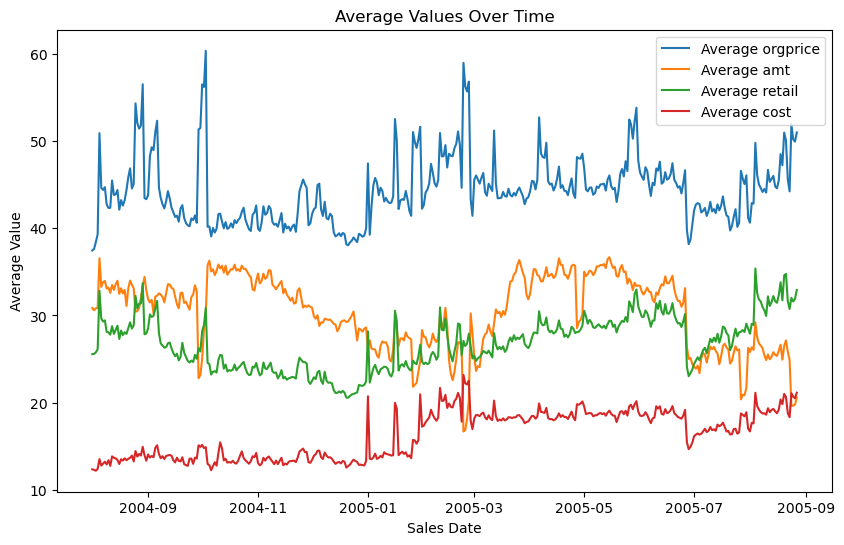

In [22]:
import matplotlib.pyplot as plt
# Step 3: Group by "saledate" and calculate the averages
grouped_df = joined_df.groupby('saledate')[['orgprice', 'amt', 'retail', 'cost']].mean().reset_index()

# Step 4: Plot the line chart
plt.figure(figsize=(10, 6))

for col in ['orgprice', 'amt', 'retail', 'cost']:
    plt.plot(grouped_df['saledate'], grouped_df[col], label=f'Average {col}')

plt.xlabel('Sales Date')
plt.ylabel('Average Value')
plt.title('Average Values Over Time')
plt.legend()
plt.show()

In [23]:
selected_brand = "MAIN ING"
analysis1 = joined_df[joined_df['brand'].str.contains(selected_brand, case=False)]
analysis1.head()

,sku,storeid,register,trannum,saledate,quantity,orgprice,amt,seq,cost,retail,day_of_week,month,weekend,percent_discount,final_sale,brand,classid,avg_discount
0,1658516,102,80,1500,2005-08-26,1,30.0,19.99,583300105,11.86,30.0,4,8,1,0.333667,0,MAIN ING,001,0.220932
1,1658516,102,140,900,2005-08-26,1,30.0,19.99,583100105,11.86,30.0,4,8,1,0.333667,0,MAIN ING,001,0.220932
2,1658516,103,111,1900,2005-08-19,1,30.0,19.99,332600067,11.86,30.0,4,8,1,0.333667,0,MAIN ING,001,0.220932
3,1658516,107,650,1100,2005-03-06,1,30.0,30.00,837600079,11.86,30.0,6,3,1,0.000000,0,MAIN ING,001,0.220932
4,1658516,107,650,1400,2005-05-13,1,30.0,30.00,666800059,11.86,30.0,4,5,1,0.000000,0,MAIN ING,001,0.220932


In [24]:
unique_counts = analysis1.nunique()
print(unique_counts)

sku                    180
storeid                326
register               277
trannum               1164
saledate               389
quantity                 1
orgprice                41
amt                    713
seq                 441173
cost                   143
retail                 179
day_of_week              7
month                   12
weekend                  2
percent_discount      1276
final_sale               2
brand                    1
classid                  9
avg_discount           180
dtype: int64


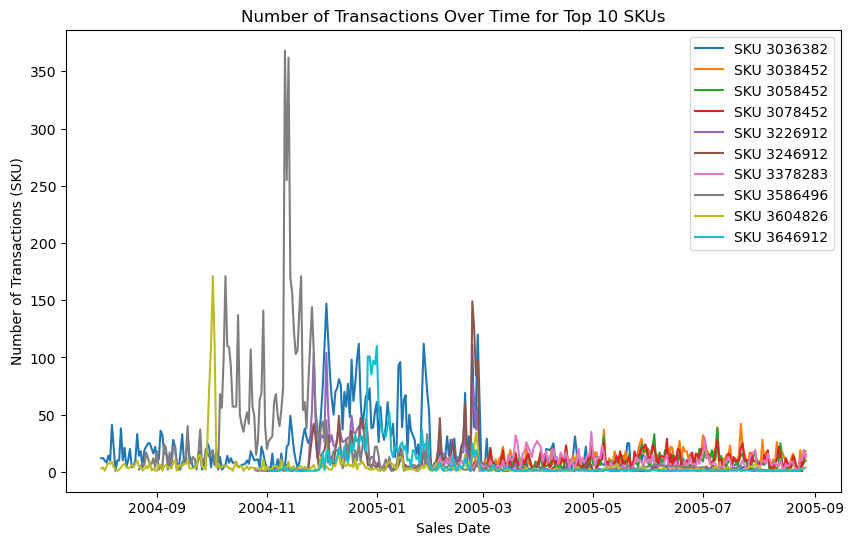

In [35]:
import matplotlib.pyplot as plt

# Step 1: Get the first 10 unique values of the "sku" column
unique_skus = analysis1['sku'].unique()[30:40]

# Step 2: Filter the DataFrame based on the first 10 unique values of "sku"
filtered_df = analysis1[analysis1['sku'].isin(unique_skus)]

# Step 3: Group by "sku" and "sales date", calculate the count of transactions (SKU)
grouped_df = filtered_df.groupby(['sku', 'saledate'])['seq'].count().reset_index()
grouped_df = grouped_df.rename(columns={'seq': 'transaction_count'})

# Step 4: Plot the line chart
plt.figure(figsize=(10, 6))

for sku in unique_skus:
    sku_data = grouped_df[grouped_df['sku'] == sku]
    plt.plot(sku_data['saledate'], sku_data['transaction_count'], label=f'SKU {sku}')

plt.xlabel('Sales Date')
plt.ylabel('Number of Transactions (SKU)')
plt.title('Number of Transactions Over Time for Top 10 SKUs')
plt.legend()
plt.show()

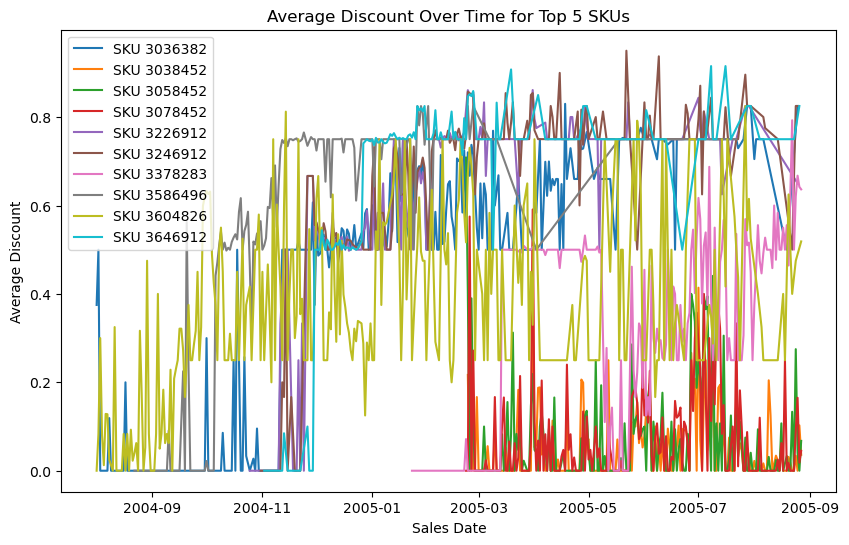

In [36]:
import matplotlib.pyplot as plt

# Step 1: Get the first 5 unique values of the "sku" column
unique_skus = analysis1['sku'].unique()[30:40]

# Step 2: Filter the DataFrame based on the first 5 unique values of "sku"
filtered_df = analysis1[analysis1['sku'].isin(unique_skus)]

# Step 3: Group by "sku" and "sales date", calculate the average of "discount"
grouped_df = filtered_df.groupby(['sku', 'saledate'])['percent_discount'].mean().reset_index()

# Step 4: Plot the line chart
plt.figure(figsize=(10, 6))

for sku in unique_skus:
    sku_data = grouped_df[grouped_df['sku'] == sku]
    plt.plot(sku_data['saledate'], sku_data['percent_discount'], label=f'SKU {sku}')

plt.xlabel('Sales Date')
plt.ylabel('Average Discount')
plt.title('Average Discount Over Time for Top 5 SKUs')
plt.legend()
plt.show()

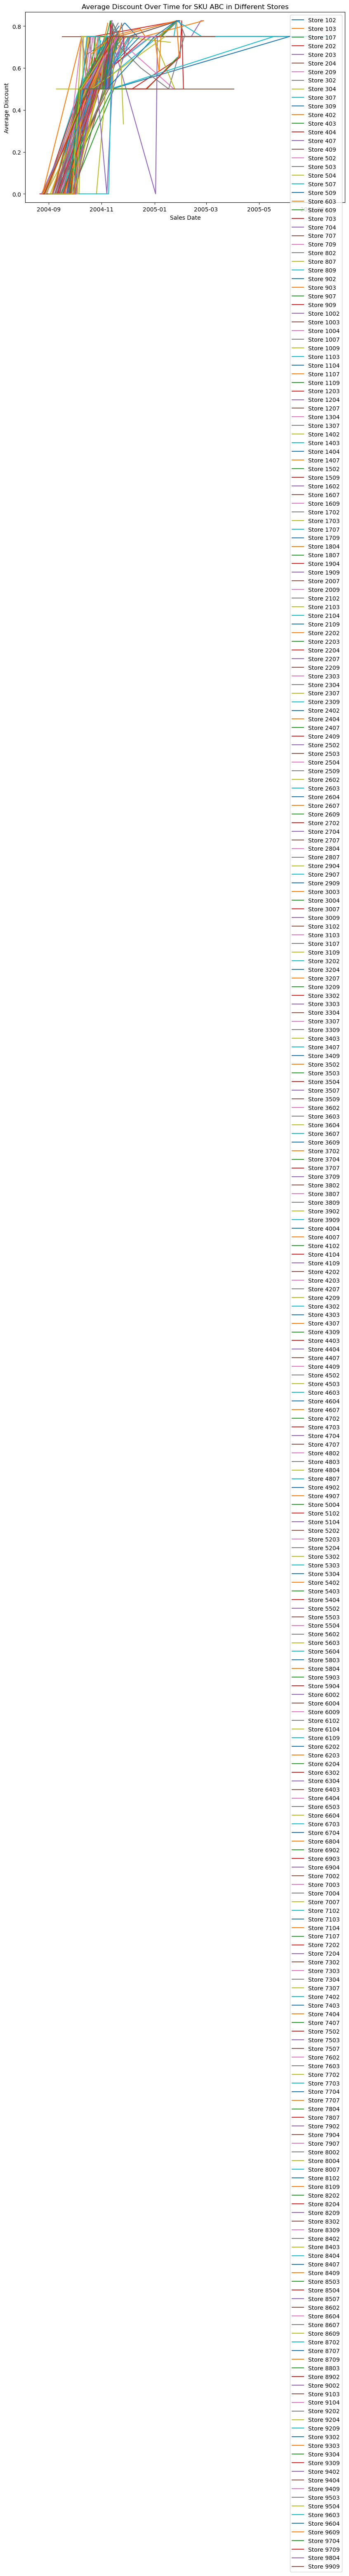

In [37]:
import matplotlib.pyplot as plt

# Step 1: Filter the DataFrame for the specific SKU "ABC"
filtered_df = joined_df[joined_df['sku'] == 3586496]

# Step 2: Group by "storeid" and "sales date", calculate the average of "discount"
grouped_df = filtered_df.groupby(['storeid', 'saledate'])['percent_discount'].mean().reset_index()

# Step 3: Plot the line chart
plt.figure(figsize=(10, 6))

for storeid in grouped_df['storeid'].unique():
    store_data = grouped_df[grouped_df['storeid'] == storeid]
    plt.plot(store_data['saledate'], store_data['percent_discount'], label=f'Store {storeid}')

plt.xlabel('Sales Date')
plt.ylabel('Average Discount')
plt.title('Average Discount Over Time for SKU ABC in Different Stores')
plt.legend()
plt.show()

In [38]:
sorted_filtered_df = filtered_df.sort_values(by="percent_discount", ascending = False)
sorted_filtered_df.head()

,sku,storeid,register,trannum,saledate,quantity,orgprice,amt,seq,cost,retail,day_of_week,month,weekend,percent_discount,final_sale,brand,classid,avg_discount
4925252,3586496,5904,820,3300,2005-01-29,1,6.0,1.05,697100126,1.5,1.500,5,1,1,0.825,1,MAIN ING,006,0.612205
4922371,3586496,1509,530,3400,2005-02-01,1,6.0,1.05,6100041,1.5,1.500,1,2,0,0.825,1,MAIN ING,006,0.612205
4926213,3586496,7804,680,700,2004-11-11,1,6.0,1.05,441700070,NaN,1.125,3,11,0,0.825,1,MAIN ING,006,0.612205
4925602,3586496,6902,190,3100,2005-01-26,1,6.0,1.05,557300090,NaN,1.125,2,1,0,0.825,1,MAIN ING,006,0.612205
4926214,3586496,7804,680,700,2004-11-11,1,6.0,1.05,441800070,NaN,1.125,3,11,0,0.825,1,MAIN ING,006,0.612205


In [47]:
sorted_filtered_df.groupby('storeid')['seq'].count().sort_values(ascending=False)

storeid
7907    75
9302    43
3807    40
3707    40
8604    37
        ..
8709     7
2303     6
9303     5
5603     3
8309     2
Name: seq, Length: 296, dtype: int64

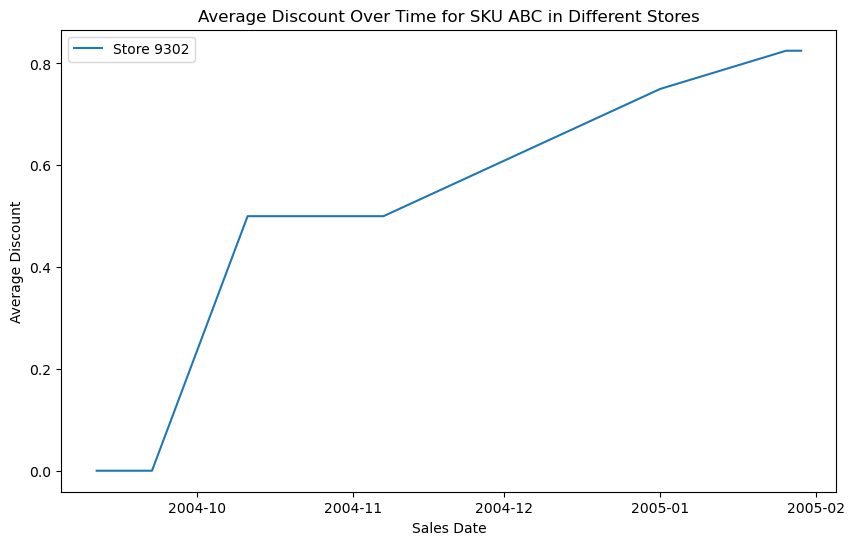

In [49]:
import matplotlib.pyplot as plt

# Step 1: Filter the DataFrame for the specific SKU "ABC"
#filtered_df = analysis1[analysis1['sku'] == 653802]
filtered_df2 = filtered_df[filtered_df['storeid'] == 9302]

# Step 2: Group by "storeid" and "sales date", calculate the average of "discount"
grouped_df = filtered_df2.groupby(['storeid', 'saledate'])['percent_discount'].mean().reset_index()

# Step 3: Plot the line chart
plt.figure(figsize=(10, 6))

for storeid in grouped_df['storeid'].unique():
    store_data = grouped_df[grouped_df['storeid'] == storeid]
    plt.plot(store_data['saledate'], store_data['percent_discount'], label=f'Store {storeid}')

plt.xlabel('Sales Date')
plt.ylabel('Average Discount')
plt.title('Average Discount Over Time for SKU ABC in Different Stores')
plt.legend()
plt.show()

In [50]:
filtered_df2.shape

(43, 19)

In [51]:
sorted_filtered_df = filtered_df.sort_values(by="saledate", ascending = True)
sorted_filtered_df.head()

,sku,storeid,register,trannum,saledate,quantity,orgprice,amt,seq,cost,retail,day_of_week,month,weekend,percent_discount,final_sale,brand,classid,avg_discount
4922366,3586496,1509,530,700,2004-08-22,1,6.0,6.0,161300068,1.5,1.500,6,8,1,0.0,0,MAIN ING,006,0.612205
4922367,3586496,1509,530,700,2004-08-22,1,6.0,6.0,161400068,1.5,1.500,6,8,1,0.0,0,MAIN ING,006,0.612205
4923067,3586496,2503,420,2700,2004-08-24,1,6.0,6.0,314200065,NaN,1.125,1,8,0,0.0,0,MAIN ING,006,0.612205
4923065,3586496,2503,420,2700,2004-08-24,1,6.0,6.0,314000065,NaN,1.125,1,8,0,0.0,0,MAIN ING,006,0.612205
4923064,3586496,2503,420,2700,2004-08-24,1,6.0,6.0,313900065,NaN,1.125,1,8,0,0.0,0,MAIN ING,006,0.612205


In [52]:
filtered_df.describe()

,sku,storeid,register,trannum,quantity,orgprice,amt,seq,cost,retail,day_of_week,month,weekend,percent_discount,final_sale,avg_discount
count,6238.0,6238.000000,6238.000000,6238.000000,6238.0,6238.0,6238.000000,6.238000e+03,406.0,6238.000000,6238.000000,6238.000000,6238.000000,6238.000000,6238.000000,6.238000e+03
mean,3586496.0,4508.246553,316.377685,2272.380090,1.0,6.0,2.326771,5.471293e+08,1.5,1.143756,3.460083,10.137865,0.552421,0.612205,0.601956,6.122048e-01
std,0.0,2875.958185,263.462435,3236.290637,0.0,0.0,1.278947,3.094749e+08,0.0,0.093820,1.859657,2.182746,0.497284,0.213158,0.489534,2.786883e-14
min,3586496.0,102.000000,10.000000,100.000000,1.0,6.0,1.050000,2.400046e+06,1.5,0.750000,0.000000,1.000000,0.000000,0.000000,0.000000,6.122048e-01
25%,3586496.0,2104.000000,110.000000,900.000000,1.0,6.0,1.500000,2.997000e+08,1.5,1.125000,2.000000,10.000000,0.000000,0.500000,0.000000,6.122048e-01
50%,3586496.0,4007.000000,220.000000,1650.000000,1.0,6.0,1.500000,5.412500e+08,1.5,1.125000,4.000000,11.000000,1.000000,0.750000,1.000000,6.122048e-01
75%,3586496.0,7204.000000,480.000000,2800.000000,1.0,6.0,3.000000,8.403000e+08,1.5,1.125000,5.000000,11.000000,1.000000,0.750000,1.000000,6.122048e-01
max,3586496.0,9909.000000,991.000000,99000.000000,1.0,6.0,6.000000,9.939002e+08,1.5,1.500000,6.000000,12.000000,1.000000,0.825000,1.000000,6.122048e-01


In [53]:
filtered_df = filtered_df[filtered_df['saledate'] == "2005-07-16"]
filtered_df.head(50)

,sku,storeid,register,trannum,saledate,quantity,orgprice,amt,seq,cost,retail,day_of_week,month,weekend,percent_discount,final_sale,brand,classid,avg_discount
4921720,3586496,707,241,3800,2005-07-16,1,6.0,1.5,562400037,1.5,1.5,5,7,1,0.75,1,MAIN ING,006,0.612205
4921721,3586496,707,241,3800,2005-07-16,1,6.0,1.5,562500037,1.5,1.5,5,7,1,0.75,1,MAIN ING,006,0.612205


In [54]:
filtered_df.shape

(2, 19)

In [55]:
unique_counts = filtered_df.nunique()
print(unique_counts)

sku                 1
storeid             1
register            1
trannum             1
saledate            1
quantity            1
orgprice            1
amt                 1
seq                 2
cost                1
retail              1
day_of_week         1
month               1
weekend             1
percent_discount    1
final_sale          1
brand               1
classid             1
avg_discount        1
dtype: int64


## Analyze SKUs (how many per day per store)

In [56]:
# Step 1: Group by "storeid," "sales date," and "sku" and count the number of items sold
grouped_df = joined_df.groupby(['storeid', 'saledate', 'sku']).size().reset_index(name='items_sold')

In [57]:
# Step 2: Calculate overall sum, number of unique stores, days, and items
overall_sum_items = grouped_df['items_sold'].sum()

In [58]:
unique_stores = grouped_df['storeid'].nunique()

In [59]:
unique_days = grouped_df['saledate'].nunique()

In [60]:
unique_items = grouped_df['sku'].nunique()

In [61]:
# Step 3: Calculate the average number of items sold per store per day
average_items_sold = overall_sum_items / (unique_stores * unique_days * unique_items)

print(f"The average number of items sold per store per day is: {average_items_sold:.2f}")

The average number of items sold per store per day is: 0.01


In [62]:
overall_sum_items

23900020

In [63]:
unique_stores

330

In [64]:
unique_days

389

In [65]:
unique_items

24431

In [66]:
average_items_sold

0.007620675681892945

## Representation of SKUs in stores

In [67]:
import matplotlib.pyplot as plt

# Assuming 'original_df' is your original DataFrame
sku_store_counts = joined_df.groupby('sku')['storeid'].nunique()

In [68]:
# Display 5 examples of items that are only sold in very few stores
few_stores_skus = sku_store_counts[sku_store_counts < 2].index[:5]
few_stores_skus

Int64Index([938984], dtype='int64', name='sku')

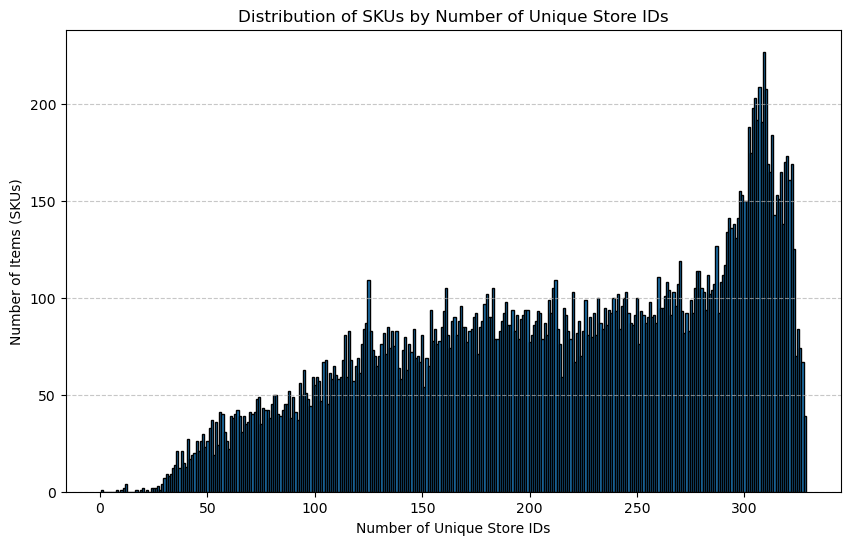

In [69]:
# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.hist(sku_store_counts, bins=range(1, sku_store_counts.max() + 2), edgecolor='black', align='left')

plt.xlabel('Number of Unique Store IDs')
plt.ylabel('Number of Items (SKUs)')
plt.title('Distribution of SKUs by Number of Unique Store IDs')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

In [ ]:
sku_20_df = joined_df[joined_df['sku'] == 20].copy()
sku_20_df.head()

In [71]:
joined_df.shape

(23900020, 19)

In [70]:
import matplotlib.pyplot as plt

item_counts = joined_df.groupby('sku').size()
item_counts.head()

sku
1634    575
3596    853
3746    480
3750    925
4190    223
dtype: int64

In [72]:
item_counts.shape

(24431,)

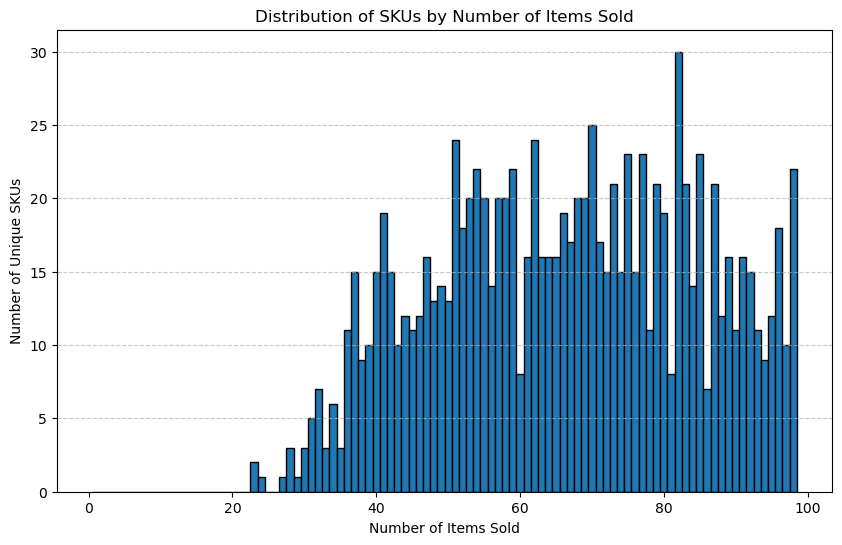

In [73]:
# Plotting the histogram
plt.figure(figsize=(10, 6))
# plt.hist(item_counts, bins=range(1, item_counts.max() + 2), edgecolor='black', align='left')
plt.hist(item_counts, range(1, 100), edgecolor='black', align='left')

plt.xlabel('Number of Items Sold')
plt.ylabel('Number of Unique SKUs')
plt.title('Distribution of SKUs by Number of Items Sold')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

## Analyze Class ID

In [74]:
# Step 1: Group by "storeid," "sales date," and "sku" and count the number of items sold
grouped_df = joined_df.groupby(['storeid', 'saledate', 'classid']).size().reset_index(name='items_sold')

In [75]:
# Step 2: Calculate overall sum, number of unique stores, days, and items
overall_sum_items = grouped_df['items_sold'].sum()
overall_sum_items

23900020

In [76]:
unique_stores = grouped_df['storeid'].nunique()
unique_stores

330

In [77]:
unique_days = grouped_df['saledate'].nunique()
unique_days

389

In [78]:
unique_items = grouped_df['classid'].nunique()
unique_items

404

In [79]:
# Step 3: Calculate the average number of items sold per store per day
average_items_sold = overall_sum_items / (unique_stores * unique_days * unique_items)

print(f"The average number of item classes sold per store per day is: {average_items_sold:.2f}")

The average number of item classes sold per store per day is: 0.46


### classes over stores

In [80]:
import matplotlib.pyplot as plt

# Assuming 'original_df' is your original DataFrame
class_store_counts = joined_df.groupby('classid')['storeid'].count()

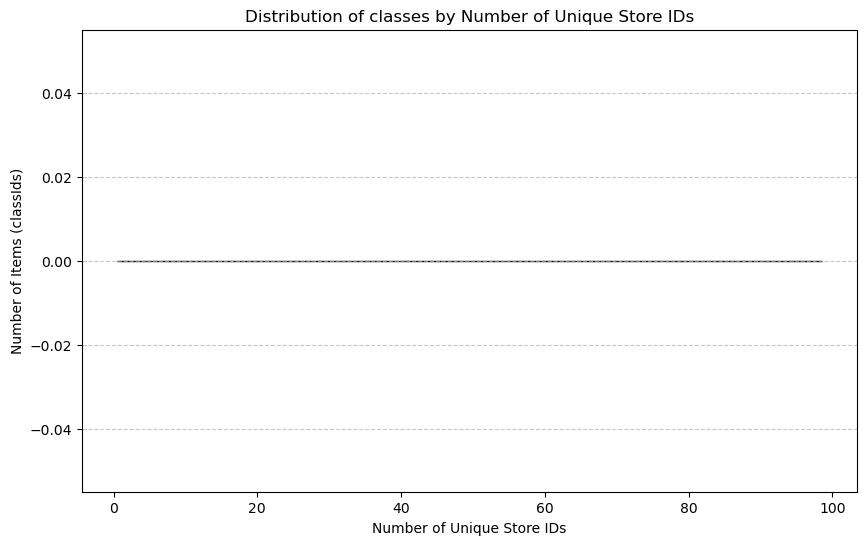

In [81]:
# Plotting the histogram
plt.figure(figsize=(10, 6))
plt.hist(class_store_counts, bins=range(1, 100), edgecolor='black', align='left')

plt.xlabel('Number of Unique Store IDs')
plt.ylabel('Number of Items (classIds)')
plt.title('Distribution of classes by Number of Unique Store IDs')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

### classes analysis

In [82]:
item_counts = joined_df.groupby('classid').size()
item_counts.head()

classid
001    2922424
002    1003796
003     686567
004     611100
005     375244
dtype: int64

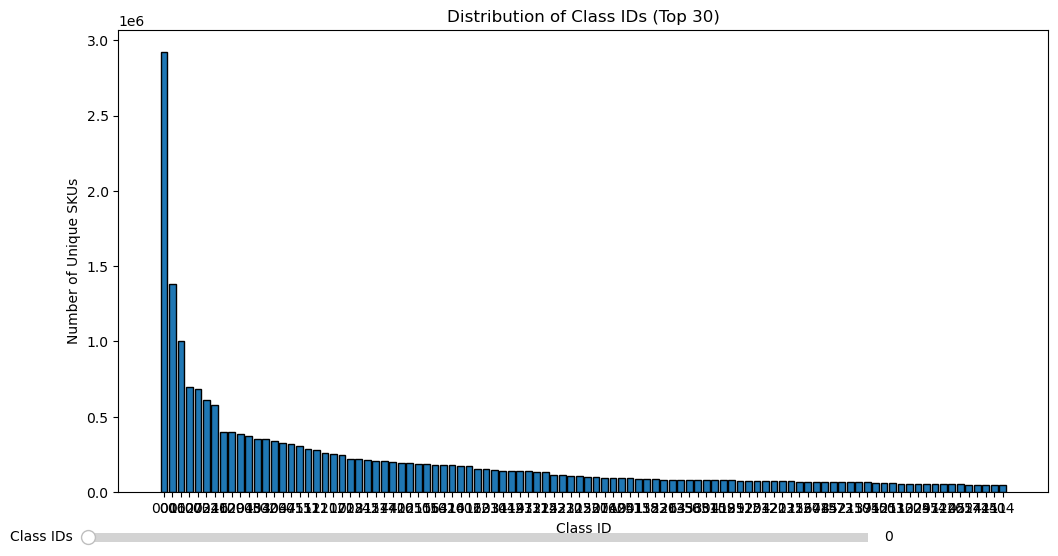

In [83]:
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider

# Assuming 'original_df' is your original DataFrame
classid_counts = joined_df.groupby('classid')['sku'].count()

# Sort classids in descending order
classid_counts = classid_counts.sort_values(ascending=False)

# Create a figure and axis
fig, ax = plt.subplots(figsize=(12, 6))

# Plot the initial bar chart for the first 30 classids
bar_width = 0.8
bar_chart = ax.bar(classid_counts.index[:100], classid_counts.values[:100], width=bar_width, edgecolor='black')

# Add labels and title
ax.set_xlabel('Class ID')
ax.set_ylabel('Number of Unique SKUs')
ax.set_title('Distribution of Class IDs (Top 30)')

# Create a slider to adjust the displayed classids
ax_slider = plt.axes([0.1, 0.02, 0.65, 0.03])
slider = Slider(ax_slider, 'Class IDs', 0, len(classid_counts) - 30, valinit=0)

def update(val):
    start_index = int(slider.val)
    end_index = start_index + 30

    ax.clear()
    bar_chart = ax.bar(classid_counts.index[start_index:end_index], classid_counts.values[start_index:end_index],
                       width=bar_width, edgecolor='black')
    
    ax.set_xlabel('Class ID')
    ax.set_ylabel('Number of Unique SKUs')
    ax.set_title(f'Distribution of Class IDs (Class IDs {start_index + 1}-{end_index})')

    plt.draw()

slider.on_changed(update)

plt.show()

## Detailed Analysis of Changes of Discounts in one item

In [84]:
# Group by SKU and StoreID, then check the number of unique percent_discount values
change_over_time = joined_df.groupby(['sku', 'storeid'])['percent_discount'].nunique()

# Filter for combinations with more than 1 unique percent_discount value
changing_combinations = change_over_time[change_over_time > 3].index

# Display the SKU-StoreID combinations with changing percent_discount
changing_combinations

MultiIndex([(   1634,  102),
            (   3596,  103),
            (   3596, 1403),
            (   3596, 1602),
            (   3596, 1607),
            (   3596, 1709),
            (   3596, 1807),
            (   3596, 2203),
            (   3596, 2504),
            (   3596, 3009),
            ...
            (9997543, 3204),
            (9997543, 4407),
            (9997543, 7507),
            (9998371, 1203),
            (9998371, 1607),
            (9998371, 9103),
            (9999235,  302),
            (9999235, 1602),
            (9999235, 5402),
            (9999235, 8002)],
           names=['sku', 'storeid'], length=364473)

In [93]:
analysis2.groupby(['sku', 'storeid'])['seq'].count().sort_values(ascending=False)

sku      storeid
6732960  9806       1147
6200129  9806       1115
1591136  9806       1043
9006887  9103       1011
5941128  9806       1006
                    ... 
3648787  8604          4
         8007          4
8966620  603           4
3648787  3309          4
6188022  9103          4
Name: seq, Length: 364473, dtype: int64

In [86]:
# Filter rows with SKU-StoreID combinations in changing_combinations
analysis2 = joined_df[joined_df.set_index(['sku', 'storeid']).index.isin(changing_combinations)]

# Display the resulting DataFrame
print(analysis2.shape)
analysis2.head()

(4817150, 19)


,sku,storeid,register,trannum,saledate,quantity,orgprice,amt,seq,cost,retail,day_of_week,month,weekend,percent_discount,final_sale,brand,classid,avg_discount
575,1658516,9309,80,1000,2005-05-07,1,30.0,4.99,893800109,11.86,30.0,5,5,1,0.833667,1,MAIN ING,001,0.220932
576,1658516,9309,80,1000,2005-06-16,1,30.0,9.99,280500058,11.86,30.0,3,6,0,0.667000,1,MAIN ING,001,0.220932
577,1658516,9309,90,900,2005-07-24,1,30.0,19.99,601600047,11.86,30.0,6,7,1,0.333667,0,MAIN ING,001,0.220932
578,1658516,9309,90,1400,2005-06-06,1,30.0,30.00,637300047,11.86,30.0,0,6,0,0.000000,0,MAIN ING,001,0.220932
579,1658516,9309,90,1400,2005-06-24,1,30.0,6.99,995700060,11.86,30.0,4,6,1,0.767000,1,MAIN ING,001,0.220932


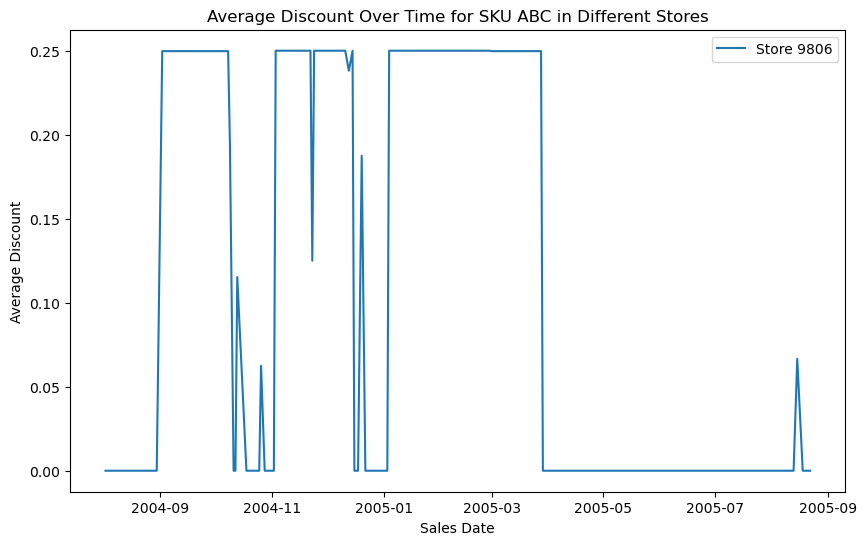

In [94]:
import matplotlib.pyplot as plt

# Step 1: Filter the DataFrame for the specific SKU "ABC"
filtered_df = analysis2[analysis2['sku'] == 6732960]
filtered_df = filtered_df[filtered_df['storeid'] == 9806]

# Step 2: Group by "storeid" and "sales date", calculate the average of "discount"
grouped_df = filtered_df.groupby(['storeid', 'saledate'])['percent_discount'].mean().reset_index()

# Step 3: Plot the line chart
plt.figure(figsize=(10, 6))

for storeid in grouped_df['storeid'].unique():
    store_data = grouped_df[grouped_df['storeid'] == storeid]
    plt.plot(store_data['saledate'], store_data['percent_discount'], label=f'Store {storeid}')

plt.xlabel('Sales Date')
plt.ylabel('Average Discount')
plt.title('Average Discount Over Time for SKU ABC in Different Stores')
plt.legend()
plt.show()

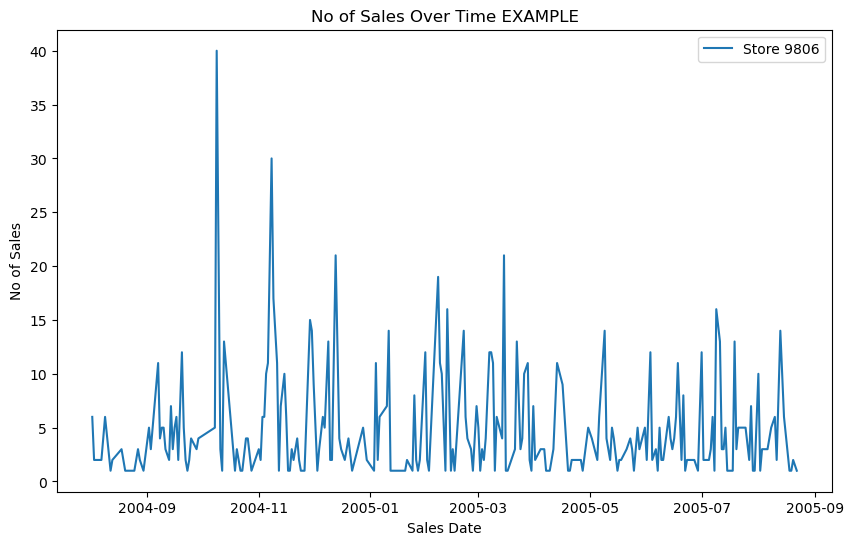

In [95]:
import matplotlib.pyplot as plt

# Step 1: Filter the DataFrame for the specific SKU "ABC"
filtered_df = analysis2[analysis2['sku'] == 6732960]
filtered_df = filtered_df[filtered_df['storeid'] == 9806]

# Step 2: Group by "storeid" and "sales date", calculate the average of "discount"
grouped_df = filtered_df.groupby(['storeid', 'saledate'])['seq'].count().reset_index()

# Step 3: Plot the line chart
plt.figure(figsize=(10, 6))

for storeid in grouped_df['storeid'].unique():
    store_data = grouped_df[grouped_df['storeid'] == storeid]
    plt.plot(store_data['saledate'], store_data['seq'], label=f'Store {storeid}')

plt.xlabel('Sales Date')
plt.ylabel('No of Sales')
plt.title('No of Sales Over Time EXAMPLE')
plt.legend()
plt.show()

## Analysis Items not sold the entire time

In [96]:
no_of_days = joined_df['saledate'].nunique()
print(no_of_days)

389


In [97]:
# Calculate the number of unique days for each SKU
sku_unique_days = joined_df.groupby('sku')['saledate'].nunique()

# Identify SKUs with fewer unique days than overall no_of_days
skus_less_unique_days = sku_unique_days[sku_unique_days < (no_of_days - 60)]

# Calculate the percentage of SKUs falling into this category
percentage_skus_less_unique_days = (len(skus_less_unique_days) / len(sku_unique_days)) * 100

# Display the SKUs and percentage
print("SKUs with fewer unique days than overall no_of_days:")
print(skus_less_unique_days)

print("\nPercentage of SKUs falling into this category: {:.2f}%".format(percentage_skus_less_unique_days))

SKUs with fewer unique days than overall no_of_days:
sku
1634       293
3596       183
3746       166
3750       180
4190       143
          ... 
9998252     88
9998371    115
9999202    140
9999235    125
9999813     59
Name: saledate, Length: 22393, dtype: int64

Percentage of SKUs falling into this category: 91.66%


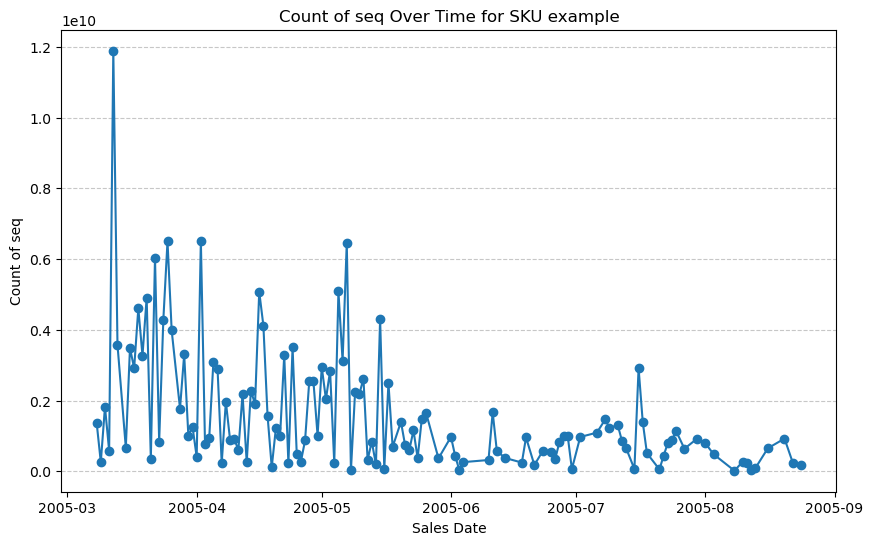

In [101]:
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

# Filter rows for the specific SKU
sku_example_data = joined_df[joined_df['sku'] == 9999235]

# Calculate the count of "seq" over time
count_seq_over_time = sku_example_data.groupby('saledate')['seq'].sum().reset_index()

# Plot the number (count) of "seq" over time
plt.figure(figsize=(10, 6))
plt.plot(count_seq_over_time['saledate'], count_seq_over_time['seq'], marker='o')

plt.xlabel('Sales Date')
plt.ylabel('Count of seq')

# Disable scientific notation on the y-axis
plt.gca().yaxis.set_major_formatter(ScalarFormatter(useMathText=False))

plt.title('Count of seq Over Time for SKU example')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

In [102]:
# Filter rows for SKUs with fewer unique days than overall no_of_days
skus_less_unique_days_data = joined_df[joined_df['sku'].isin(skus_less_unique_days.index)]

# Calculate the overall revenue
overall_revenue = joined_df['retail'].sum()

# Calculate the revenue for SKUs with fewer unique days
revenue_skus_less_unique_days = skus_less_unique_days_data['retail'].sum()

# Calculate the percentage of overall revenue
percentage_revenue_skus_less_unique_days = (revenue_skus_less_unique_days / overall_revenue) * 100

# Display the percentage of overall revenue
print("Percentage of overall revenue accounted for by SKUs with fewer unique days: {:.2f}%".format(percentage_revenue_skus_less_unique_days))

Percentage of overall revenue accounted for by SKUs with fewer unique days: 82.48%


In [103]:
max_rev = skus_less_unique_days_data.groupby('sku')['retail'].sum().reset_index()
max_rev = max_rev.sort_values(by="retail", ascending = False)
max_rev.head()

,sku,retail
22312,9956667,1159990.0
1355,660826,919724.0
2797,1357342,883844.0
20205,8966664,850155.0
6233,2913537,843600.0


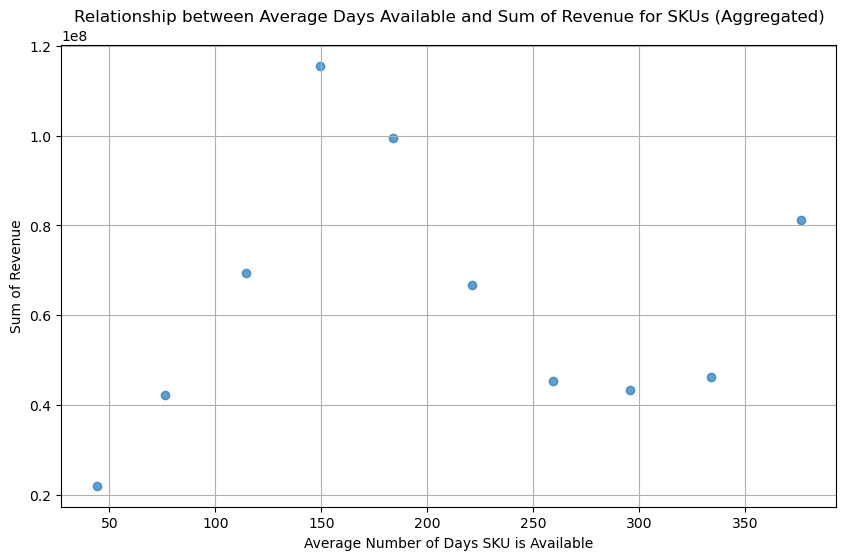

In [104]:
import matplotlib.pyplot as plt
import pandas as pd

# Calculate the number of days a SKU is available in the data
sku_days_available = joined_df.groupby('sku')['saledate'].nunique()

# Calculate the sum of revenue for each SKU
sku_sum_revenue = joined_df.groupby('sku')['retail'].sum()

# Combine data into a DataFrame
df_combined = pd.DataFrame({'DaysAvailable': sku_days_available, 'SumRevenue': sku_sum_revenue})

# Create bins for the number of days available
bins = pd.cut(df_combined['DaysAvailable'], bins=10)

# Aggregate data within each bin
agg_data = df_combined.groupby(bins).agg({'DaysAvailable': 'mean', 'SumRevenue': 'sum'})

# Create a scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(agg_data['DaysAvailable'], agg_data['SumRevenue'], alpha=0.7)

plt.xlabel('Average Number of Days SKU is Available')
plt.ylabel('Sum of Revenue')
plt.title('Relationship between Average Days Available and Sum of Revenue for SKUs (Aggregated)')
plt.grid(True)

plt.show()


### Relationship btw classes and sku (most important)

## Price Elasticity Model

In [105]:
# Filter rows for the specific SKU
sku_example_data = joined_df[joined_df['sku'] == 6732960]

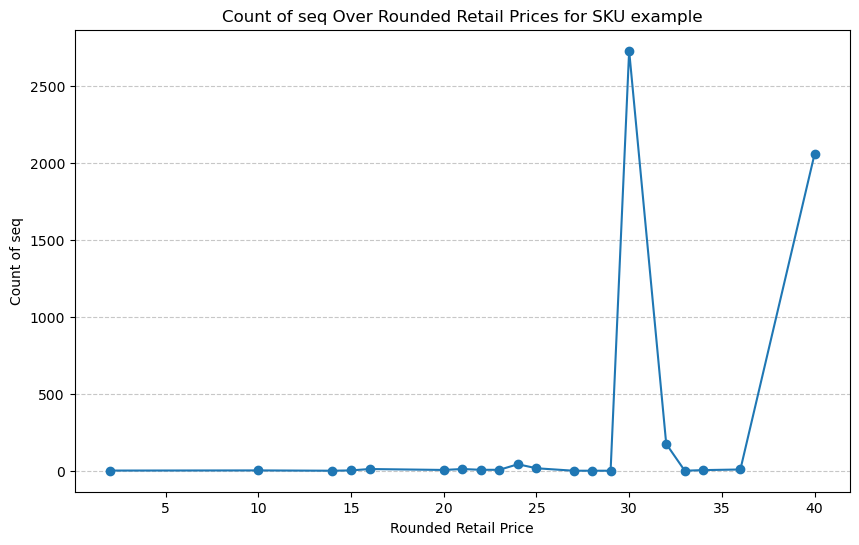

In [106]:
import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter

# Round the 'retail' column to 0 digits
sku_example_data['rounded_retail'] = sku_example_data['amt'].round(0)

# Calculate the count of "seq" over rounded prices
count_seq_over_price = sku_example_data.groupby('rounded_retail')['seq'].count().reset_index()

# Plot the number (count) of "seq" over rounded prices
plt.figure(figsize=(10, 6))
plt.plot(count_seq_over_price['rounded_retail'], count_seq_over_price['seq'], marker='o')

plt.xlabel('Rounded Retail Price')
plt.ylabel('Count of seq')

# Disable scientific notation on the y-axis
plt.gca().yaxis.set_major_formatter(ScalarFormatter(useMathText=False))

plt.title('Count of seq Over Rounded Retail Prices for SKU example')
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

In [107]:
sku_example_data.head()

,sku,storeid,register,trannum,saledate,quantity,orgprice,amt,seq,cost,retail,day_of_week,month,weekend,percent_discount,final_sale,brand,classid,avg_discount,rounded_retail
12665236,6732960,102,70,7300,2004-12-22,1,40.0,40.00,744600042,24.0,40.0,2,12,0,0.0000,0,GORHAM/T,001,0.151711,40.0
12665237,6732960,102,70,7300,2004-12-22,1,40.0,40.00,744700042,24.0,40.0,2,12,0,0.0000,0,GORHAM/T,001,0.151711,40.0
12665238,6732960,102,120,4000,2004-10-30,1,40.0,15.98,68800026,24.0,40.0,5,10,1,0.6005,1,GORHAM/T,001,0.151711,16.0
12665239,6732960,102,120,4000,2004-10-30,1,40.0,15.98,68900026,24.0,40.0,5,10,1,0.6005,1,GORHAM/T,001,0.151711,16.0
12665240,6732960,102,120,4000,2004-10-30,1,40.0,15.98,69000026,24.0,40.0,5,10,1,0.6005,1,GORHAM/T,001,0.151711,16.0


In [108]:
sku_example_data.nunique()

sku                    1
storeid              284
register             215
trannum              514
saledate             383
quantity               1
orgprice               1
amt                   26
seq                 5061
cost                   1
retail                 1
day_of_week            7
month                 12
weekend                2
percent_discount      26
final_sale             2
brand                  1
classid                1
avg_discount           1
rounded_retail        20
dtype: int64

In [109]:
## Analysis to make sure discount is correct

In [110]:
sku_example_data = analysis1.copy()
sku_example_data.size

9744910

In [111]:
sku_example_data['discount_dollars'] = sku_example_data['orgprice'] - sku_example_data['amt']
sku_example_data.head()

,sku,storeid,register,trannum,saledate,quantity,orgprice,amt,seq,cost,retail,day_of_week,month,weekend,percent_discount,final_sale,brand,classid,avg_discount,discount_dollars
0,1658516,102,80,1500,2005-08-26,1,30.0,19.99,583300105,11.86,30.0,4,8,1,0.333667,0,MAIN ING,001,0.220932,10.01
1,1658516,102,140,900,2005-08-26,1,30.0,19.99,583100105,11.86,30.0,4,8,1,0.333667,0,MAIN ING,001,0.220932,10.01
2,1658516,103,111,1900,2005-08-19,1,30.0,19.99,332600067,11.86,30.0,4,8,1,0.333667,0,MAIN ING,001,0.220932,10.01
3,1658516,107,650,1100,2005-03-06,1,30.0,30.00,837600079,11.86,30.0,6,3,1,0.000000,0,MAIN ING,001,0.220932,0.00
4,1658516,107,650,1400,2005-05-13,1,30.0,30.00,666800059,11.86,30.0,4,5,1,0.000000,0,MAIN ING,001,0.220932,0.00


In [114]:
sku_example_data2 = sku_example_data[sku_example_data['sku'] == 1658516]
print(sku_example_data2.size)
sku_example_data2.head()

12560


,sku,storeid,register,trannum,saledate,quantity,orgprice,amt,seq,cost,retail,day_of_week,month,weekend,percent_discount,final_sale,brand,classid,avg_discount,discount_dollars
0,1658516,102,80,1500,2005-08-26,1,30.0,19.99,583300105,11.86,30.0,4,8,1,0.333667,0,MAIN ING,001,0.220932,10.01
1,1658516,102,140,900,2005-08-26,1,30.0,19.99,583100105,11.86,30.0,4,8,1,0.333667,0,MAIN ING,001,0.220932,10.01
2,1658516,103,111,1900,2005-08-19,1,30.0,19.99,332600067,11.86,30.0,4,8,1,0.333667,0,MAIN ING,001,0.220932,10.01
3,1658516,107,650,1100,2005-03-06,1,30.0,30.00,837600079,11.86,30.0,6,3,1,0.000000,0,MAIN ING,001,0.220932,0.00
4,1658516,107,650,1400,2005-05-13,1,30.0,30.00,666800059,11.86,30.0,4,5,1,0.000000,0,MAIN ING,001,0.220932,0.00


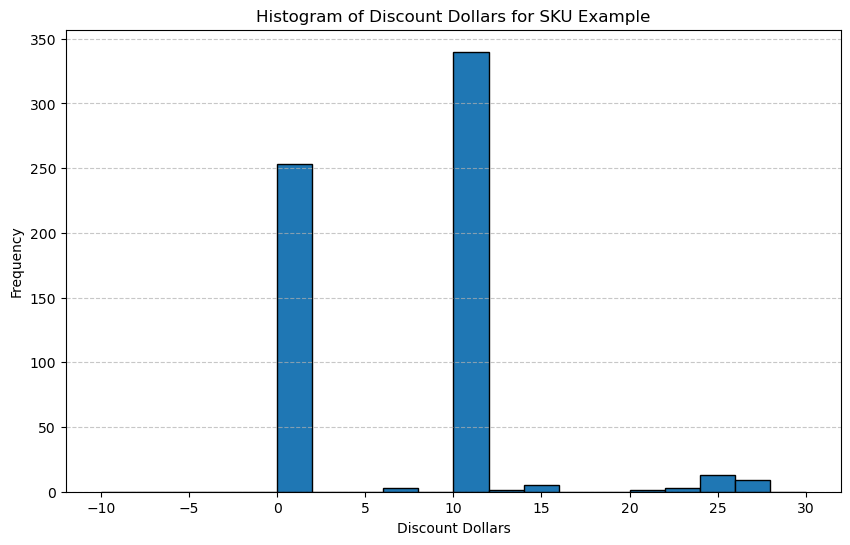

In [115]:
# Create a histogram with 20 buckets and a specified range
plt.figure(figsize=(10, 6))
plt.hist(sku_example_data2['discount_dollars'], bins=20, range=(-10, 30), edgecolor='black')

plt.xlabel('Discount Dollars')
plt.ylabel('Frequency')
plt.title('Histogram of Discount Dollars for SKU Example')

plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

## Test

In [ ]:
# Step 1: Calculate the percentage of retail for each SKU from the most common retail price
sku_percentage_retail = joined_df.groupby('sku').apply(
    lambda group: group['retail'] / group['retail'].sum()
).reset_index(level=0, drop=True)

# Step 2: Create a new column 'flag' based on the calculated percentage
joined_df['flag'] = 'diff'  # Default to 'diff'
joined_df.loc[sku_percentage_retail >= 0.95, 'flag'] = 'same'

# Step 3: Analyze the distribution of the 'flag' column
flag_distribution = joined_df['flag'].value_counts(normalize=True)

# Display the distribution
print(flag_distribution)

In [ ]:
# Step 1: Calculate the percentage of retail for each SKU from the most common retail price
sku_percentage_retail = analysis1.groupby('sku').apply(
    lambda group: group['amt'] / group['amt'].sum()
).reset_index(level=0, drop=True)

In [ ]:
# Step 2: Create a new column 'flag' based on the calculated percentage
analysis1['flag'] = 'diff'  # Default to 'diff'
analysis1.loc[sku_percentage_retail >= 0.95, 'flag'] = 'same'

In [ ]:
# Step 3: Analyze the distribution of the 'flag' column
flag_distribution = analysis1['flag'].value_counts(normalize=True)
# Display the distribution
print(flag_distribution)

In [ ]:
# Step 1: Calculate the percentage of retail for each SKU from the most common retail price
sku_percentage_retail_sum = joined_df.groupby('sku').sum('amt')
sku_percentage_retail_max = joined_df.groupby(['sku']).max(count_unique('amt'))

# Prepare for PE Model

In [232]:
joined_df.groupby(['sku'])['seq'].count().sort_values(ascending=False).head()

sku
6656135    47786
9552306    39612
5278362    37871
3348362    32674
7313673    30095
Name: seq, dtype: int64

In [266]:
correlation_df = joined_df.groupby(['saledate', 'sku']).agg({'seq': 'count', 'amt': 'mean'}).reset_index()
correlation = correlation_df.groupby('sku')['amt', 'seq'].corr().iloc[0::2, 1].reset_index()
print(f'Correlation coefficient: {correlation}')

Correlation coefficient:            sku level_1       seq
0         1634     amt -0.081341
1         3596     amt -0.188831
2         3746     amt -0.251793
3         3750     amt -0.309281
4         4190     amt -0.307594
...        ...     ...       ...
24426  9998252     amt -0.246845
24427  9998371     amt -0.565320
24428  9999202     amt -0.138617
24429  9999235     amt  0.446243
24430  9999813     amt -0.345551

[24431 rows x 3 columns]


In [263]:
# Sort the values by correlation coefficient in descending order
correlation_sorted = correlation.dropna(subset=['seq'])
correlation_sorted = correlation_sorted.sort_values(by='seq', ascending=False)
correlation_sorted

,sku,level_1,seq
7293,3086216,amt,0.725082
11741,4866329,amt,0.689348
7888,3306173,amt,0.669481
17967,7336633,amt,0.668821
19020,7736633,amt,0.656121
...,...,...,...
2504,1127472,amt,-0.819420
2400,1087472,amt,-0.825530
22864,9318373,amt,-0.826901
22958,9368373,amt,-0.827393


In [282]:
correlation_sorted[(correlation_sorted['seq'] > -0.4) & (correlation_sorted['seq'] < -0.2)]

,sku,level_1,seq
12036,4969268,amt,-0.200014
8524,3573551,amt,-0.200041
4866,2139624,amt,-0.200053
3975,1784411,amt,-0.200065
14836,6073796,amt,-0.200096
...,...,...,...
2692,1219217,amt,-0.399631
21285,8634273,amt,-0.399705
10109,4209666,amt,-0.399711
8367,3498121,amt,-0.399824


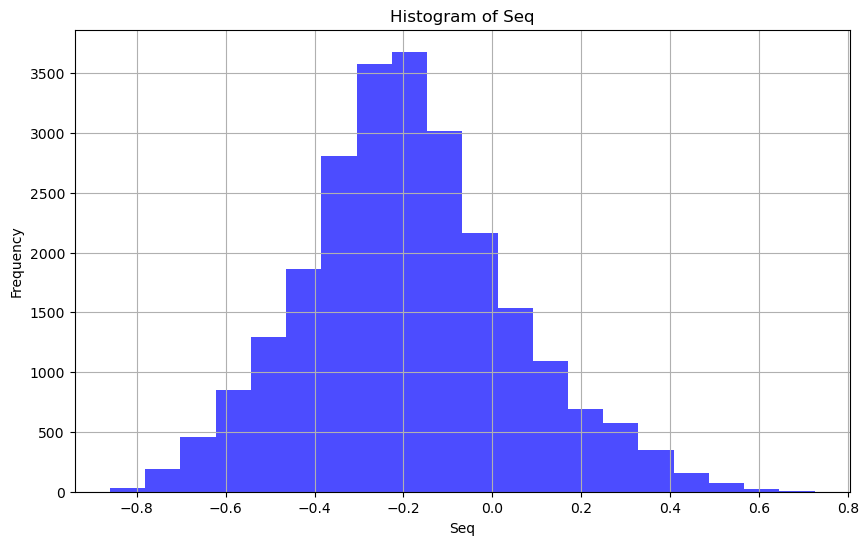

In [264]:
# Create a histogram of the 'seq' column
plt.figure(figsize=(10, 6))
plt.hist(correlation_sorted['seq'], bins=20, color='blue', alpha=0.7)
plt.title('Histogram of Seq')
plt.xlabel('Seq')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [258]:
correlation_df = joined_df.groupby(['saledate','sku']).agg({'seq': 'count', 'amt': 'mean'}).reset_index()

In [259]:
correlation = correlation_df['amt'].corr(correlation_df['seq'])
print(f'Correlation coefficient: {correlation}')

Correlation coefficient: -0.4698156731401169


### 1 single model per sku

In [297]:
#sku_example_data = joined_df[joined_df['sku'] == 7578118]
sku_example_data = joined_df[joined_df['sku'] == 1127472]
pe_model_df = sku_example_data.copy()

In [298]:
pe_model_df.shape

(2503, 19)

In [299]:
pe_model_df.head()

,sku,storeid,register,trannum,saledate,quantity,orgprice,amt,seq,cost,retail,day_of_week,month,weekend,percent_discount,final_sale,brand,classid,avg_discount
22862049,1127472,102,400,1900,2005-01-27,1,25.0,25.0,29200120,9.46,12.5,3,1,0,0.0,0,ROUNDTRE,117,0.236271
22862050,1127472,102,400,3100,2005-06-10,1,25.0,25.0,564900035,9.46,12.5,4,6,1,0.0,0,ROUNDTRE,117,0.236271
22862051,1127472,102,400,3900,2005-06-12,1,25.0,25.0,83300025,9.46,12.5,6,6,1,0.0,0,ROUNDTRE,117,0.236271
22862052,1127472,102,420,2400,2005-01-28,1,25.0,25.0,304700135,9.46,12.5,4,1,1,0.0,0,ROUNDTRE,117,0.236271
22862053,1127472,102,530,800,2005-04-11,1,25.0,25.0,68800029,9.46,12.5,0,4,0,0.0,0,ROUNDTRE,117,0.236271


In [300]:
correlation_df = pe_model_df.groupby('saledate').agg({'seq': 'count', 'amt': 'mean'}).reset_index()

In [301]:
correlation = correlation_df['amt'].corr(correlation_df['seq'])
print(f'Correlation coefficient: {correlation}')

Correlation coefficient: -0.8194202466323911


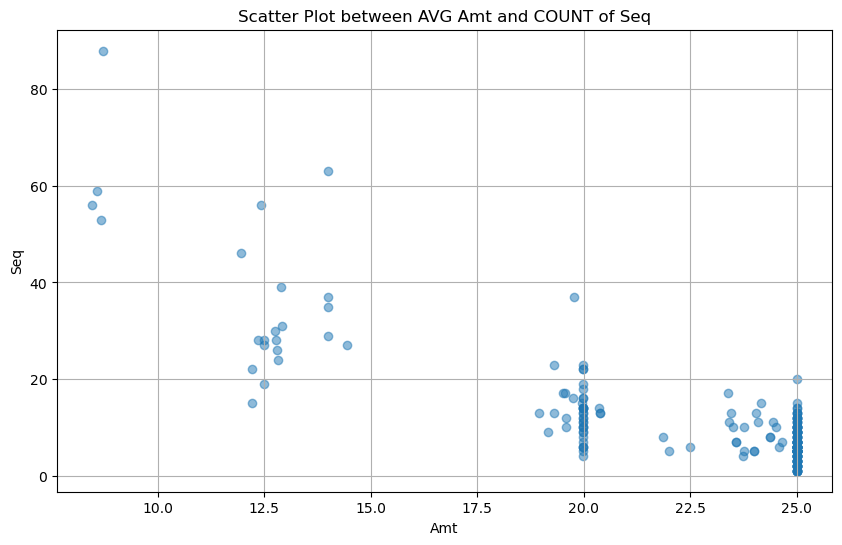

In [302]:
# Scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(correlation_df['amt'], correlation_df['seq'], alpha=0.5)
plt.title('Scatter Plot between AVG Amt and COUNT of Seq')
plt.xlabel('Amt')
plt.ylabel('Seq')
plt.grid(True)
plt.show()

### to be cleaned up (linear regression)

## Improved Model

Mean Squared Error: 54.062116603226535
R-squared: 0.607226727671089


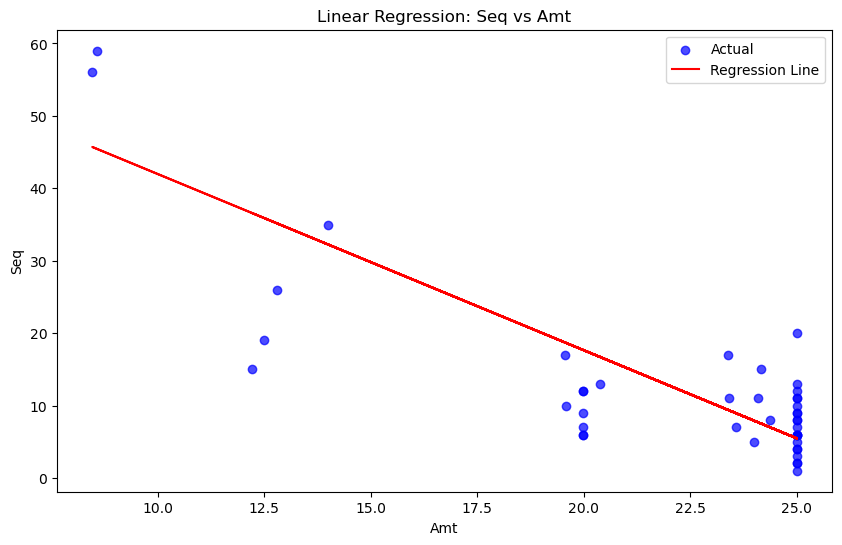

In [303]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Split the data into training and testing sets
X = correlation_df[['amt']]
y = correlation_df['seq']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

# Plot the regression line
plt.figure(figsize=(10, 6))
plt.scatter(X_test, y_test, color='blue', alpha=0.7, label='Actual')
plt.plot(X_test, y_pred, color='red', label='Regression Line')
plt.title('Linear Regression: Seq vs Amt')
plt.xlabel('Amt')
plt.ylabel('Seq')
plt.legend()
plt.show()
